
# 1D Wasserstein barycenter demo

This example illustrates the computation of regularized Wasserstein Barycenter
as proposed in [3].


[3] Benamou, J. D., Carlier, G., Cuturi, M., Nenna, L., & Peyré, G. (2015).
Iterative Bregman projections for regularized transportation problems
SIAM Journal on Scientific Computing, 37(2), A1111-A1138.


In [3]:
# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 1

import numpy as np
import matplotlib.pyplot as plt
import ot
# necessary for 3d plot even if not used
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection

## Generate data



In [4]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=20, s=5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=60, s=8)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

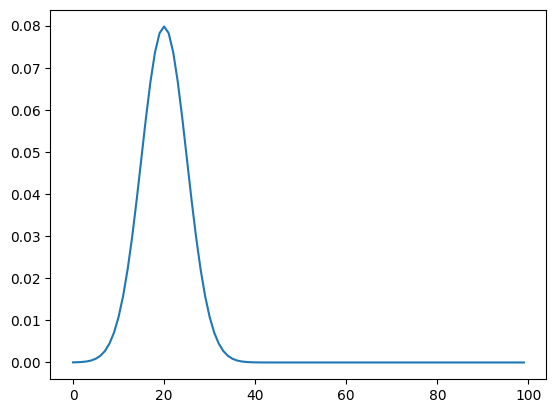

In [7]:
plt.plot(a1)
plt.show()

## Barycenter computation



In [15]:
def geometricBar(weights, alldistribT):
    """return the weighted geometric mean of distributions"""
    assert (len(weights) == alldistribT.shape[1])
    return np.exp(np.dot(np.log(alldistribT), weights.T))


def geometricMean(alldistribT):
    """return the  geometric mean of distributions"""
    return np.exp(np.mean(np.log(alldistribT), axis=1))

### Sinkhorn type algo for OT Barycenter
def barycenter_sinkhorn(marginals, cost, epsilon, weights = None, maxiter=1000, stopThr=1e-4):

    K = np.exp(-cost/epsilon)
    cpt = 0
    err = 1
    vT = np.divide(marginals.T, np.sum(K, axis=0))
    UKv = np.dot(K, vT.T)
    u = (geometricMean(UKv) / UKv.T).T

    ###
    # u = np.ones((100,2))
    ###
    while (cpt < maxiter):# err > stopThr and
        cpt = cpt + 1
        Ku = np.dot(K, u)
        v = np.divide(marginals, Ku)
        Kv = np.dot(K,v)
        UKv = u*Kv
        # UKv = u * np.dot(K, np.divide(marginals, np.dot(K, u)))
        u = (u.T * geometricBar(weights, UKv)).T / UKv

    return geometricBar(weights, UKv)

def calculate_n_barycenter_sinkhorn(marginals, cost, epsilon, maxiter, num_timepoints):
    ret = []
    for time_idx in range(num_timepoints):  # 0<=alpha<=1
        alpha = time_idx/num_timepoints
        weights = np.array([1-alpha, alpha])

        barycenter1 = barycenter_sinkhorn(marginals, cost, epsilon=epsilon, weights=weights, maxiter=maxiter)
        ret.append(barycenter1.reshape(1, -1))
    return np.concatenate(ret, axis=0)

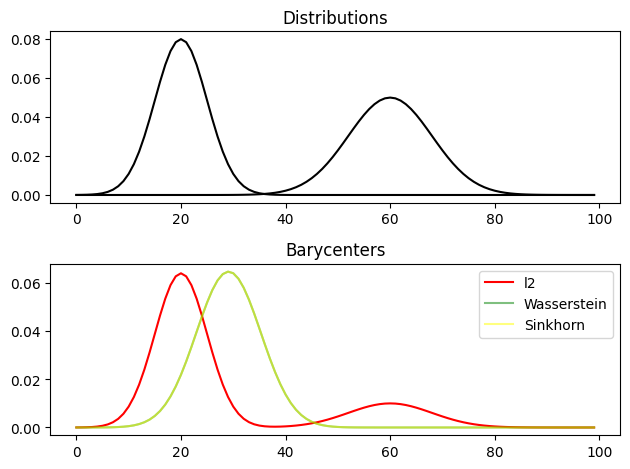

In [24]:
alpha = 0.2  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# l2bary
bary_l2 = A.dot(weights)

# wasserstein
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg, weights)

f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, num=1)
ax1.plot(x, A, color="black")
ax1.set_title('Distributions')

ax2.plot(x, bary_l2, 'r', label='l2')
ax2.plot(x, bary_wass, 'g', label='Wasserstein', alpha=0.5)
ax2.plot(x, barycenter_sinkhorn(A, M, reg, weights=weights, maxiter=1000), 'yellow', label='Sinkhorn', alpha=0.5)
ax2.set_title('Barycenters')

plt.legend()
plt.show()

## Barycentric interpolation



In [9]:
n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)


B_l2 = np.zeros((n, n_alpha))

B_wass = np.copy(B_l2)

for i in range(n_alpha):
    alpha = alpha_list[i]
    weights = np.array([1 - alpha, alpha])
    B_l2[:, i] = A.dot(weights)
    B_wass[:, i] = ot.bregman.barycenter(A, M, reg, weights)

/tmp/ipykernel_3725424/1177088273.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipykernel_3725424/1177088273.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


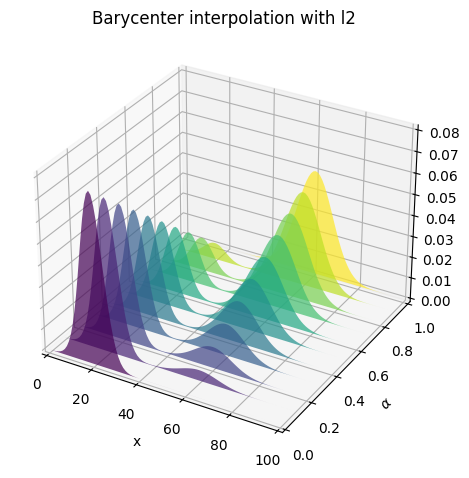

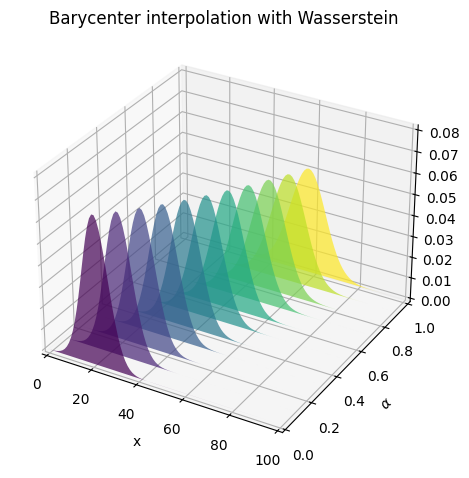

In [10]:
plt.figure(2)

cmap = plt.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_l2[:, i]
    verts.append(list(zip(x, ys)))

ax = plt.gcf().add_subplot(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
plt.title('Barycenter interpolation with l2')
plt.tight_layout()

plt.figure(3)
cmap = plt.cm.get_cmap('viridis')
verts = []
zs = alpha_list
for i, z in enumerate(zs):
    ys = B_wass[:, i]
    verts.append(list(zip(x, ys)))

ax = plt.gcf().add_subplot(projection='3d')

poly = PolyCollection(verts, facecolors=[cmap(a) for a in alpha_list])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.set_xlabel('x')
ax.set_xlim3d(0, n)
ax.set_ylabel('$\\alpha$')
ax.set_ylim3d(0, 1)
ax.set_zlabel('')
ax.set_zlim3d(0, B_l2.max() * 1.01)
plt.title('Barycenter interpolation with Wasserstein')
plt.tight_layout()

plt.show()